In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" #"all" "none"

### Inverted Pendulum Swingup problem
https://gymnasium.farama.org/environments/classic_control/pendulum/ 
https://www.gymlibrary.dev/environments/classic_control/pendulum/

Observation space: 
- $cos(\theta)$
- $sin(\theta)$ 
- angular velocity $\dot{\theta}$ in range(-8,8) 

Action space: torque applied to free end +ve counter clockwise 

Goal: swing to upright position  ($\theta$ = 0 , x=1 y=0) - x and y on opposite axes - check diagram 

objective is to maintain the pendulum in the upright position 

Reward: $r = -(\theta^2 + 0.1 * \dot{\theta}^2 + 0.001 * \tau^2)$ 

The starting state is a random angle in [-pi, pi] and a random angular velocity in [-1,1]. 
An episode truncates at 200 time steps.

<img src="../figures/pendulum.png" width="100" height="100">


- Plot intermediate activations as 2D rate maps of neurons - theta (0-360) vs velocity
- atoms should predict one sample
- compare all neurons activations to when atoms predict another sample (change latent seed)
- entropy, tsne, linear decoding from activations to source - over layers and neurons

### Load all

In [2]:
import sys
# Add the parent directory to the Python path
# sys.path.append(os.path.abspath('..'))
import os
os.chdir(os.path.abspath('..')) 

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import model_viz_functions_pendulum as modelviz_pendulum_utils
import model_viz_loaders as modelviz_loaders
# from model_viz_functions_riab import plot_samples 

import os
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

# import copy

2024-10-01 23:35:21.638420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 23:35:21.638480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 23:35:21.638503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 23:35:22.771322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[23:35:24] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=772668;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=499948;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=222966;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=650754;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=706678;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=529950;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:227: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None = None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/train.py:119: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Arr

### ENV and MODEL path and dataset

In [4]:
ENVIRONMENT = "Pendulum-v1" 
model_path = "logdir_pendulum" 

In [5]:
dataset = datasets.make_dataset(ENVIRONMENT)
print("Dataset observations shape: ",dataset.observation.shape)

# import pathlib 
# import pickle 
# dataset_path = pathlib.Path("datasets/pendulum_test/sac/dataset.pkl")
# with open(dataset_path, "rb") as f:
#     dataset1 = pickle.load(f)
# folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])

Dataset observations shape:  (500001, 3)


In [6]:
env_og = envs.make(ENVIRONMENT)  #config.env
env = stade.GymEnvWrapper(env_og, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

### Model stuff - restoring checkpoint

In [7]:
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

[23:35:32] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=651268;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=380614;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=455627;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=937624;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=422286;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=961453;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[23:35:40] INFO     Restoring item from                                                         ]8;id=252645;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=862158;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir_pendulum/500000.                               

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=948086;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=203742;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir_pendulum/500000.                               

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 8, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 3), 'kernel': (10, 32, 3)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 3
)>


In [8]:
assert state.generator.apply_fn.__self__.num_state_dims == dataset.observation.shape[1]
print(" env in config is correct")
# except AssertionError:
    # print("Warning: Please check the environment settings in configs.py. The number of state dimensions in the model does not match the shape of the dataset observations.")

 env in config is correct


In [9]:
num_samples= 32 #config.plot_num_samples # Number of state samples the model should generate
num_outer=config.num_outer # Number of model atoms   
num_latent_dims= config.latent_dims # Dimension of input noise 
print('observation_spec shape:', env.observation_spec().shape[0], ' num_latent_dims ',num_latent_dims)
print(f'DSM model input (n_samples {num_samples}, n_atoms {num_outer}, atom_input {num_latent_dims+env.observation_spec().shape[0]}) ')

observation_spec shape: 3  num_latent_dims  5
DSM model input (n_samples 32, n_atoms 10, atom_input 8) 


### Source states

In [10]:
def get_states(n_steps, theta_range=[0,2*np.pi], thetadot_range=[-8,8]):
    """
        for # inputs from pi/2 to 3pi/2  - below the pendulum bar: get_states(50, theta_range = [np.pi/2, 3*np.pi/2],thetadot_range=[-4,4])
        returns `n_steps`^2 states from pendulum environment,
        sampling angle and angular velocity uniformly within environment bounds
    """
    theta_range = np.linspace(*theta_range, n_steps)
    thetadot_range = np.linspace(*thetadot_range, n_steps)[::-1]

    states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for thetadot in thetadot_range
        for theta in theta_range
    ])

    return states, theta_range, thetadot_range

def get_condition_states():
    """
        returns a few representative conditioning states
    """
    thetas = [np.pi/2, np.pi, np.pi*3/2]
    thetadots = [-4, 0, 4]

    condition_states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for theta in thetas
        for thetadot in thetadots
    ])
    
    return condition_states, thetas, thetadots

# sources_all, *_ = get_states(50)
# sources_all.shape

# from dsm import plotting
# saved_source_states = plotting.source_states(config.env) 
# # has 2 lists of 9 elements each - each element is a list of 2 elements  - states:[theta, thetadot] observations: [sin(theta), cos(theta), thetadot]
# # print('polar coords, angular velocity',saved_source_states[0]) 
# # print('cartesian coords, angular velocity',saved_source_states[1])
# sources_all = saved_source_states[1]

In [16]:
sources_test, *_ = get_condition_states()

In [12]:
# from dsm import rewards
# # for reward_fn_name, reward_fn in getattr(rewards, config.env).items():
# from dsm.plotting import utils as plot_utils
# reward_fn_name = 'Default'
# reward_fn = getattr(rewards, config.env)[reward_fn_name]
# reward_fn
def _angle_normalize(x: jax.Array) -> jax.Array:
    return np.round(((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi,2)
def pendulum_no_action_penalty(states, a=None) -> jax.Array:
    # del a
    if len(states) == 3:
        t = jnp.arctan2(states[1], states[0]) # angle to the vertical arctan2(sin_theta, cos_theta)
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif len(states)==2:
        t = states[0]
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif states.ndim == 2:
        if states.shape[1] == 3:
            cos_theta = states[:,0]
            sin_theta = states[:,1]
            theta = np.arctan2(sin_theta, cos_theta)
        elif states.shape[1] == 2:
            theta = states[:,0]
        thetadot = states[:,-1]
        costs = _angle_normalize(theta)**2 + .1*thetadot**2 #+ .001*(u**2)

        return -costs

reward_fn = pendulum_no_action_penalty 

# plt.rcParams['figure.figsize'] = [2, 3]
# n_steps = 41
# queries, theta_range, thetadot_range = get_states(n_steps)
# rewards = reward_fn(queries)

# rewards_2d = rewards.reshape(n_steps, n_steps)
# plt.imshow(rewards_2d, aspect='auto', cmap='inferno')
# # plt.gca().invert_yaxis()
# plt.xticks([])
# plt.yticks([])
# plt.colorbar()
# # plt.tight_layout()
# # scatter = plt.contourf(theta_range, thetadot_range, rewards_2d, cmap='inferno')

In [13]:
import importlib 
importlib.reload(modelviz_pendulum_utils)

# rewards = pendulum_no_action_penalty(dataset.observation)
# # colors = range(len(thetas))
# plt.scatter(thetas, velocities, alpha=0.5, s=1,  c=rewards, cmap='viridis')

<module 'model_viz_functions_pendulum' from '/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_pendulum.py'>

### compute DSM samples

atom_input = latent+source_state <br>
DSM model input (n_samples, n_atoms, atom_input)

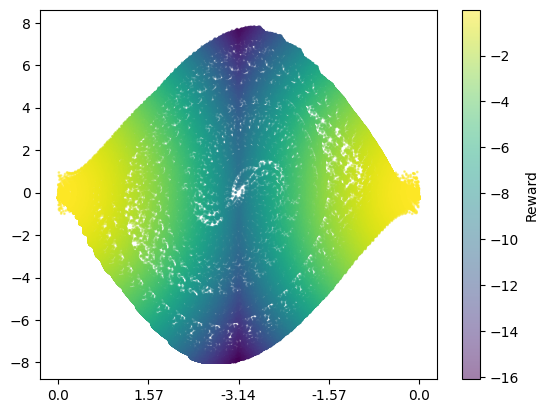

In [13]:
# # Left scatter plot
# # converts Cartesian coordinates to polar coordinates (thetas) and extracts velocities
ENVIRONMENT = "Pendulum-v1"
dataset = datasets.make_dataset(ENVIRONMENT)
thetas = np.arctan2(dataset.observation[:, 1], dataset.observation[:, 0]) % (2 * np.pi)
velocities = dataset.observation[:, -1]
rewards = pendulum_no_action_penalty(dataset.observation)
# colors = range(len(thetas))
plt.scatter(thetas, velocities, alpha=0.5, s=1,  c=rewards, cmap='viridis') #color="grey")
# plt.xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
angles_base = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
plt.xticks(angles_base, (_angle_normalize(t) for t in angles_base))
# normalized_angles = [_angle_normalize(t) for t in angles_base]
# labels = ["0", "π/2", "π/-π", "-π/2", "0"]  # Custom labels for the normalized angles
# Set the x-ticks with the normalized angles and the corresponding labels
# plt.xticks(normalized_angles, labels)
plt.colorbar(label="Reward")

In [18]:
source_idx = 0
source_state_current = sources_test[source_idx]
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, 
        source_state_current=source_state_current, num_samples = 32
    )
samples_test = samples

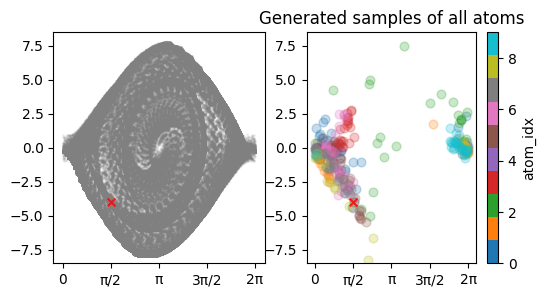

In [16]:
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=True, atom='all')

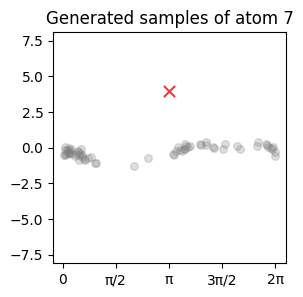

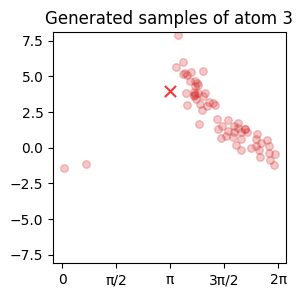

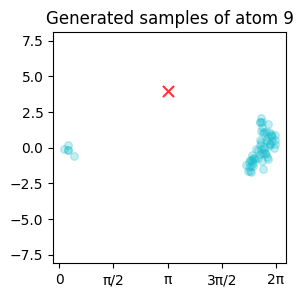

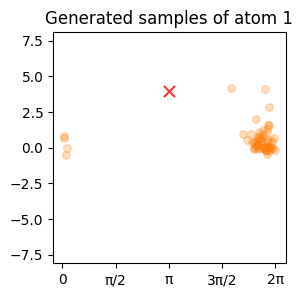

In [28]:
source_state_current = sources_test[5]
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source_state_current, num_samples = 64
    )
atom_idx = 7
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 3
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 9
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 1
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 

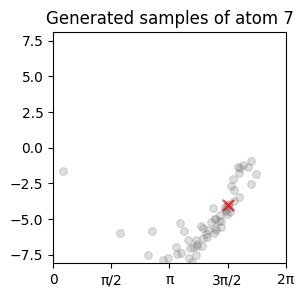

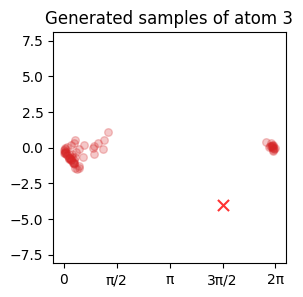

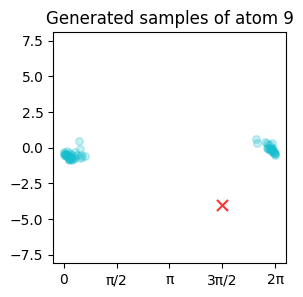

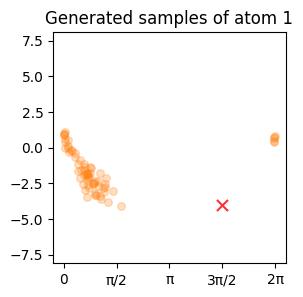

In [27]:
source_state_current = sources_test[6]
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source_state_current, num_samples = 64
    )
atom_idx = 7
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 3
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 9
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 
atom_idx = 1
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx) 

## Experiments

#### Predictions of each atom 
- 1 prediction from all source states 
- Plots for each atom
- Effect of latents - if atom predictions in a manifold, less effect of randomness

DSM model input (n_samples, n_atoms, state_dims + latent_dims)
- To generate 1 sample , 1 atom's input = state_dims + random_latent_dims



In [42]:
sources_all, theta_all, thetadot_all = get_states(20) #get_condition_states()

Processing atoms: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_pendulum.py:382: UserWarning: The figure layout has changed to tight
  # plt.yticks([])


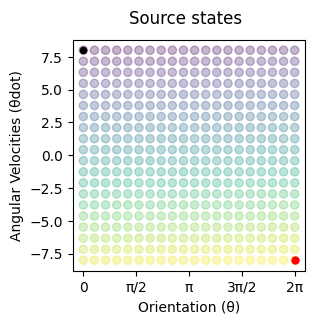

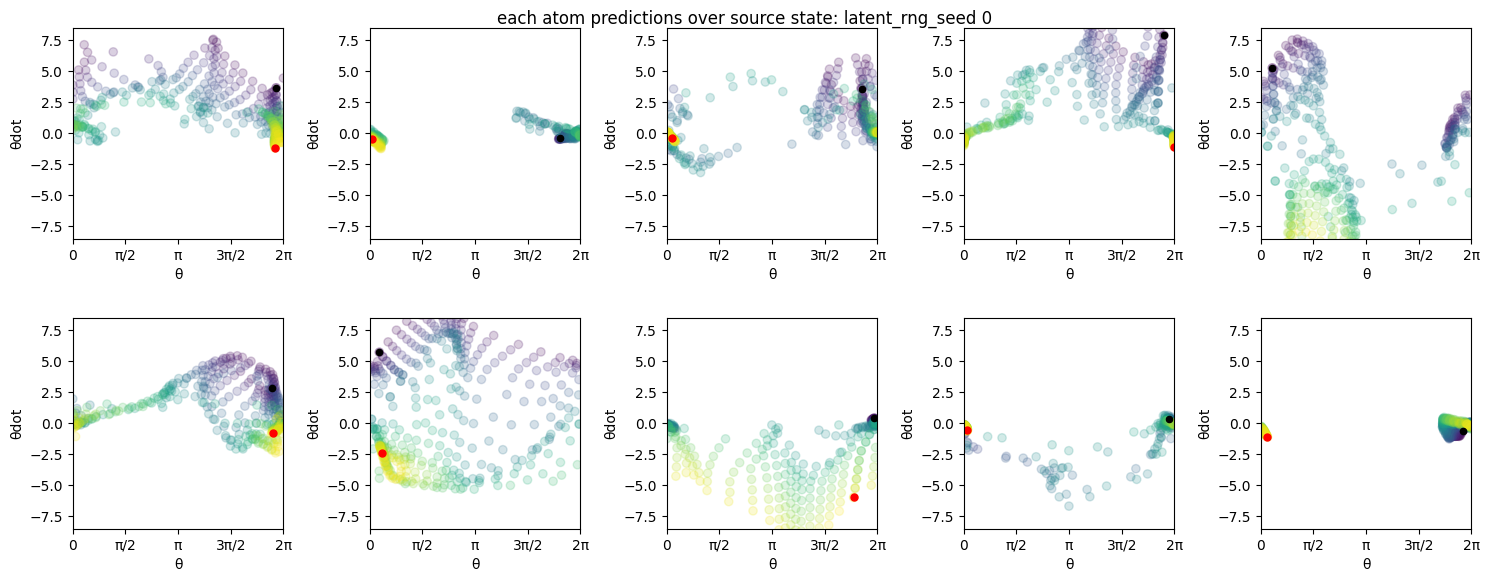

In [43]:
# 1 sample prediction from each atom in a subplot - colored by source state
# sources_all, *_ = get_condition_states()

# Plot 1: Source states
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
thetas = np.arctan2(sources_all[:, 1], sources_all[:, 0]) % (2 * np.pi)
velocities = sources_all[:, -1]
colors = range(len(thetas))  # Create a list of numbers from 0 to len(xs)-1
# reversed_map = plt.cm.get_cmap('viridis') .reversed() 
scatter = axs.scatter(thetas, velocities, alpha=0.3, c=colors, cmap='viridis')  # Use the numbers as colors
axs.scatter(thetas[0], velocities[0], color='k',s=20)
axs.scatter(thetas[-1], velocities[-1], color='red',s=25)
axs.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
axs.set_xlabel('Orientation (θ)') 
axs.set_ylabel('Angular Velocities (θdot)')
fig.suptitle('Source states')
sources_all.shape
latent_rng_seed = 0

# Plot 2: Atom predictions - 1 sample
modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
                              title='each atom predictions over source state: latent_rng_seed 0')
# latent_rng_seed = 2
# modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
#                               title='each atom predictions over source state: latent_rng_seed 2')

Processing atoms:  10%|█         | 1/10 [00:08<01:15,  8.34s/it]

debug shape:  (100, 5, 3)


Processing atoms: 100%|██████████| 10/10 [00:58<00:00,  5.82s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_pendulum.py:509: UserWarning: The figure layout has changed to tight
  ax.set_title(f'Atom{k}')


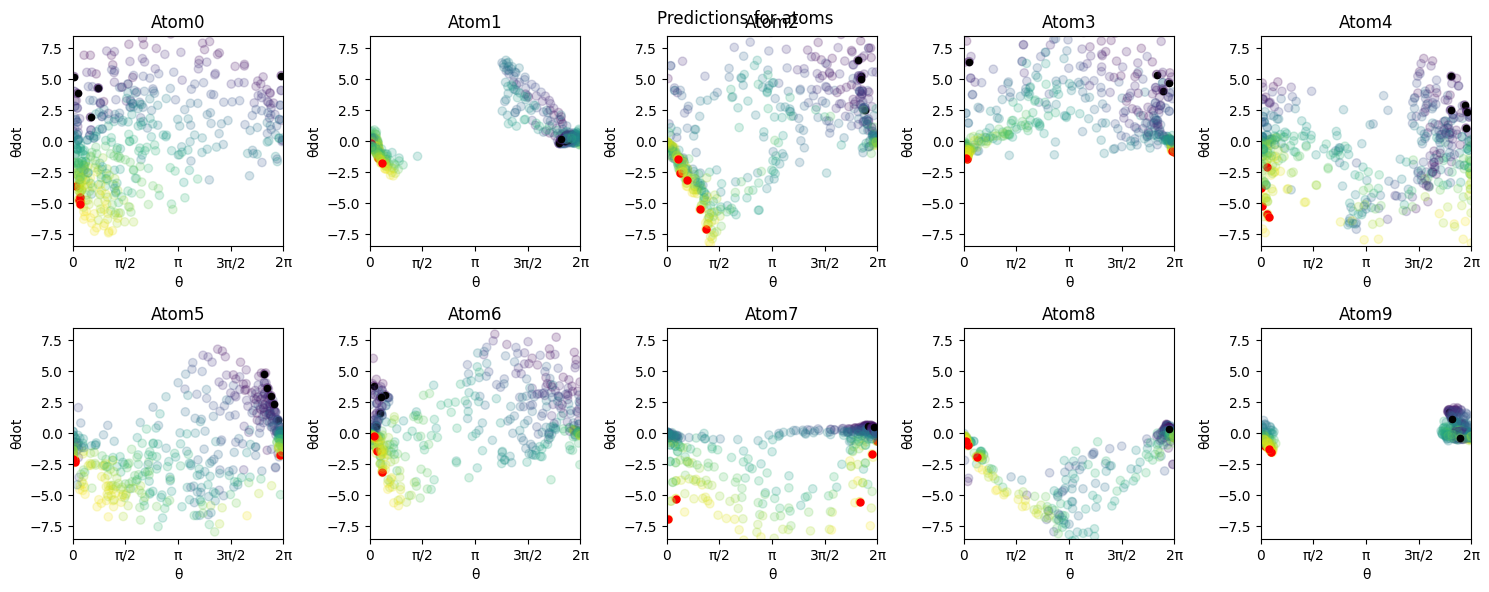

In [75]:
# Multiple predictions from each atom in a subplot - colored by source state
latent_rng_seed = 40
num_samples = 5
preds1 = modelviz_pendulum_utils.get_multiple_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel='all', 
                                                       num_samples=num_samples, title='Predictions for atoms')
modelviz_pendulum_utils.plot_multiple_predictions_atoms(preds1, num_samples=num_samples, title='Predictions for atoms')

Processing atoms:  10%|█         | 1/10 [00:11<01:45, 11.70s/it]

debug shape:  (400, 2, 3)


Processing atoms: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_pendulum.py:509: UserWarning: The figure layout has changed to tight
  ax.set_title(f'Atom{k}')


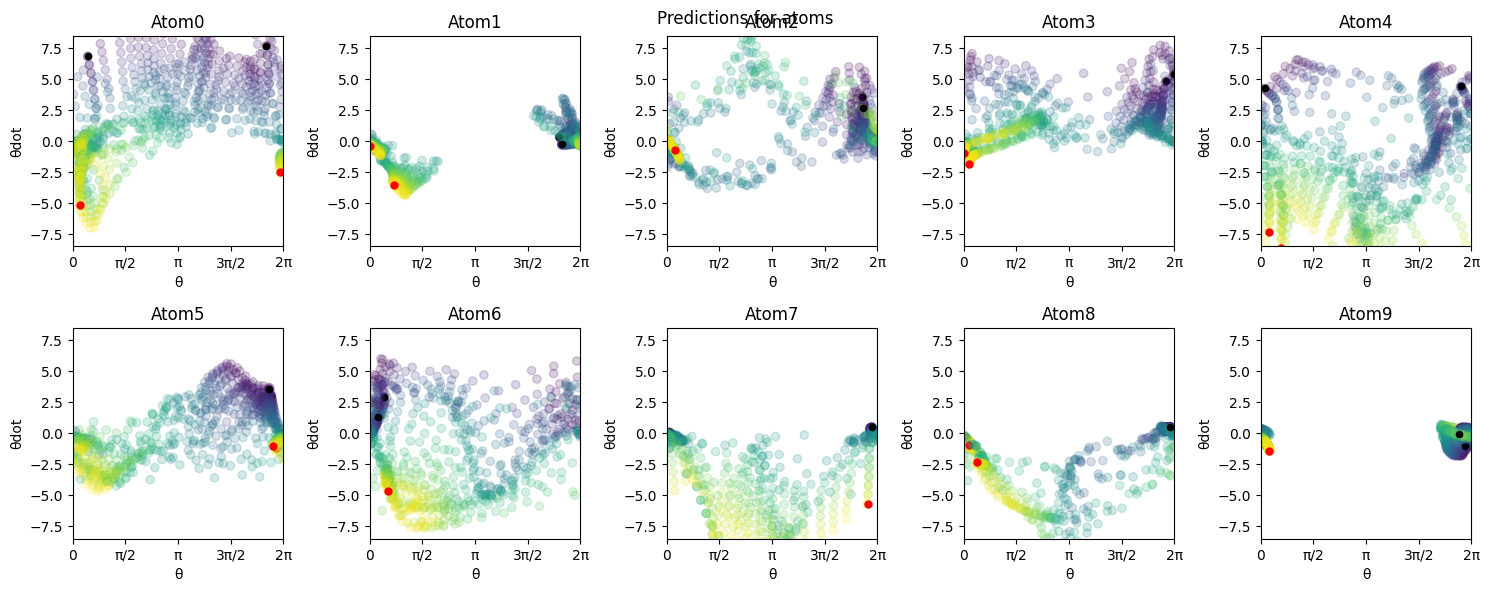

In [44]:
# Multiple predictions from each atom in a subplot - colored by source state
latent_rng_seed = 5
num_samples = 2
preds1 = modelviz_pendulum_utils.get_multiple_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel='all', 
                                                       num_samples=num_samples, title='Predictions for atoms')
modelviz_pendulum_utils.plot_multiple_predictions_atoms(preds1, num_samples=num_samples, title='Predictions for atoms')

900 source states, 10 samples predicted by each atom
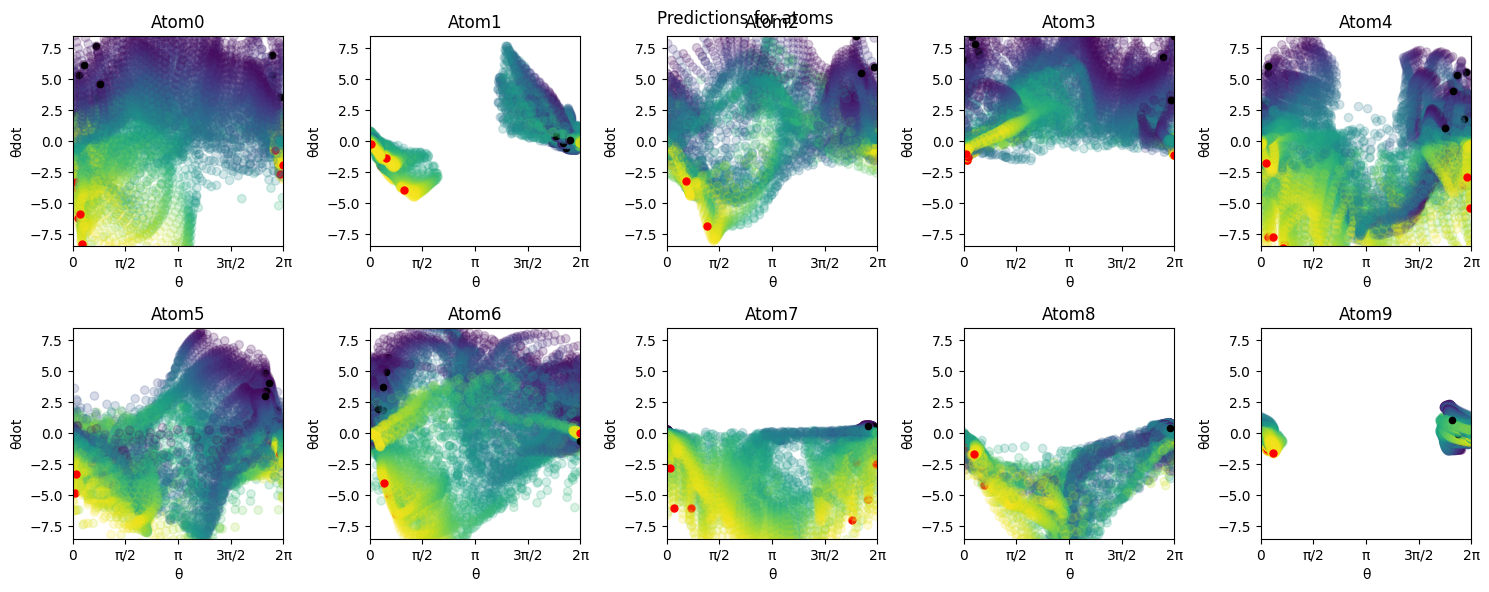

After experimenting with different latent seeds and more number of samples, we observe consistent patterns among some atoms
- Atom 9 seems to  show very localized behavior, primarily predicting the states highly rewarded during policy
- Atom 1 seems to be somewhat similar to atom 9 but a somewhat wider range close to the training goal states
- Atom 7 seems to limit all its predictions to half of the state space (we only observe angular velocities between -8 and 0) while for atom 3 we observe predictions of angular velocities in range (-1,8)

### Dense 3 activations  - output ratemaps over cos(theta) , sin(theta), angular velocity

In [57]:
# All atoms - return specified layer activation - Plot rate map of neuron_idx
def explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed, sources_all):
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
    activations_layer_all_atoms = [] 
    for atom_num in range(config.num_outer):
        atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
        activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator, atom_params, sources_all,zs, layers)
        # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
        activations_layer_all_atoms.append(activations_layer) 
    return activations_layer_all_atoms

In [55]:
sources_all, theta_all, thetadot_all = get_states(10) #get_condition_states()

In [58]:
# All atoms - activation of neuron predicting angular velocity - plot rate map
layers = ['Dense_3',]
latent_rng_seed = 20
# print(f'Layer: {layers} - Neuron: {neuron_idx}- Angular Velocity')
activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed,sources_all)


In [60]:
import matplotlib.colors as mcolors

In [53]:
# Plot with respect to angular velocity (Dense 3 neuron 2) or theta = arctan(Dense 3 neuron1 output, neuron2 output)
# single sample prediction from each atom in a subplot 

def plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, theta_all, thetadot_all, srcdim='ang_velocity'):
    
    n = len(activations_layer_all_atoms) # 10
    cols = 5 
    rows = n // cols 
    position = range(1,n + 1)
    fig = plt.figure(figsize=(10,4))

    # Find global min and max
    if srcdim == 'ang_velocity':
        global_min = -8
        global_max = 8
        chosenlabel = 'Predicted Angular Velocity (θdot)'
    elif srcdim == 'orientation':
        global_min = -np.pi
        global_max = np.pi
        chosenlabel='Predicted Orientation (θ)'
    norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

    # scatters = []
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for k, activations_layer in enumerate(activations_layer_all_atoms): 
        ax = fig.add_subplot(rows, cols, position[k])
        label = f'Atom: {k}'

        if srcdim == 'ang_velocity':
            chosen_pred = activations_layer[:, 2]
        elif srcdim == 'orientation':
            chosen_pred = np.arctan2(activations_layer[:, 0], activations_layer[:, 1])
        activations_2d = chosen_pred.reshape(len(thetadot_all), len(theta_all))

        # scatter = ax.imshow(activations_2d, cmap='inferno', vmin=global_min, vmax=global_max, aspect='auto')
        # ax.set_aspect('equal')
        scatter = ax.contourf(theta_all, thetadot_all, activations_2d, 
                            cmap='inferno', levels=20, norm=norm) # vmin=global_min, vmax=global_max
        ax.set_box_aspect(1)

        # scatters.append(scatter)
        if n==num_outer:
            ax.set_title(f'Atom{k}')
        plt.xticks([]), plt.yticks([]) 
        ax.set_xlabel('θ')
        ax.set_ylabel('θdot')
    # Create colorbar as a common for all subplots.
    # fig.colorbar(scatters[0], ax=fig.get_axes(), label='Predicted Angular Velocity (θdot)', norm=norm)
    # Create a ScalarMappable for the colorbar with the global norm and colormap
    sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
    sm.set_array([])  # This is required to create the colorbar
    fig.colorbar(sm, ax=fig.get_axes(), label=chosenlabel)
    # fig.suptitle('Thetadot predictions')
    plt.show()

# individual colorbars
# neuron_idx=2 # angular velocity
# modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 
#                                                                       'Atom', neuron_idx, 
#                                                                       theta_all, thetadot_all, normalize=False) 
#                                                                         #,title='Velocity predictions'


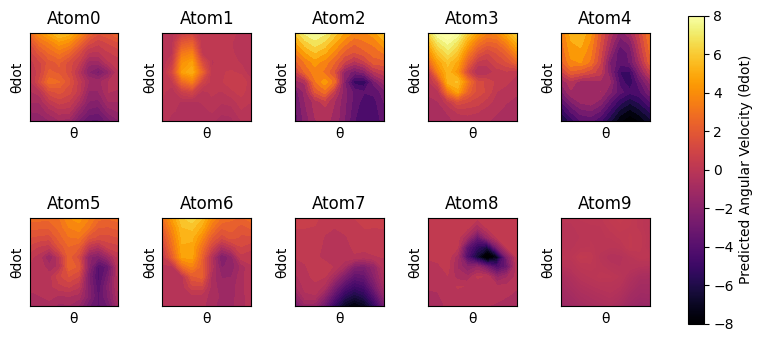

In [61]:
plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, theta_all, thetadot_all, srcdim='ang_velocity')

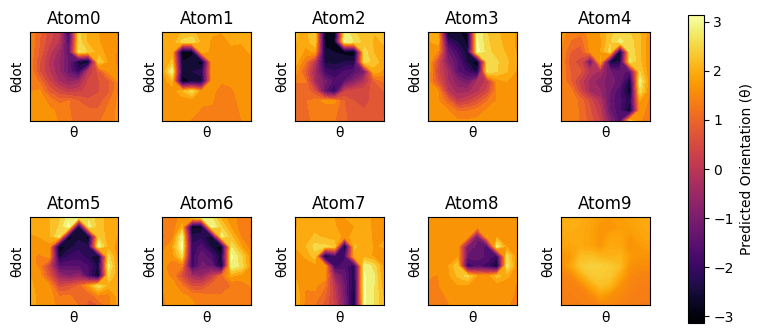

In [81]:
plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, theta_all, thetadot_all, srcdim='orientation')

Different latent seed to see if common patterns

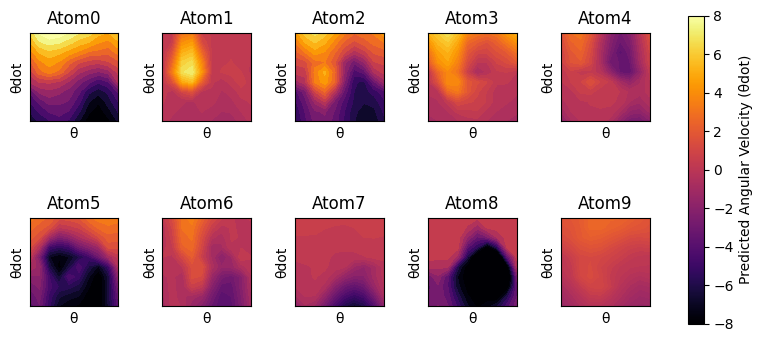

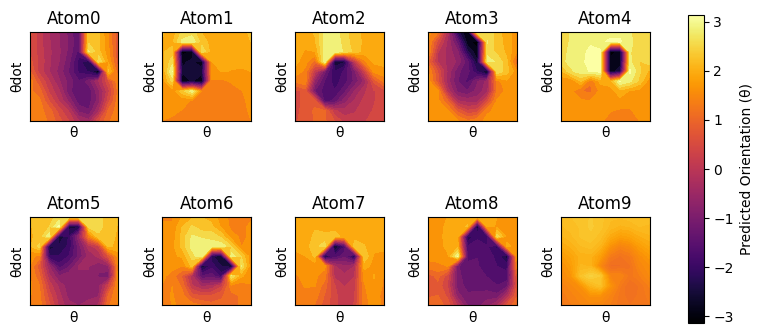

In [84]:
# All atoms - activation of neuron predicting angular velocity - plot rate map
layers = ['Dense_3',]
latent_rng_seed = 42
# print(f'Layer: {layers} - Neuron: {neuron_idx}- Angular Velocity')
activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed,sources_all)

plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, theta_all, thetadot_all, srcdim='ang_velocity')
plot_atom_activations_wrt_chosen_source_dim(activations_layer_all_atoms, theta_all, thetadot_all, srcdim='orientation')

### To see if internal neurons of an atom is selective for certain environmental features

To generate 1 sample , 1 atom's input = state_dims + random_latent_dims

- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity
- invariance across latents
- Entrop: - average over each dim of orientation and velocity
- t-SNE or UMAP
- Linear decoder from activations to source / end state

In [36]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 7  # ith atom
sources_all, theta_all, thetadot_all = get_states(10) #get_condition_states()


atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
print(jax.tree_map(jnp.shape, atom_params))

layers = ['Dense_0','Dense_1','Dense_2','Dense_3'] # All intermediate layers
latent_rng_seed = 0
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(
                    state.generator, atom_params, sources_all, zs, layers)
for keys,values in zip(atom_activations_alllayers.keys(), atom_activations_alllayers.values()):
    print(keys, values.shape)

# import joblib
# joblib.dump(atom_activations_alllayers, model_path+f'/activations_alllayers_atom{atom_i}_latent{latent_rng_seed}.pkl')

# layers = ['Dense_3',]
# latent_rng_seed = 0
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all, zs, layers)

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (8, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (3,), 'kernel': (32, 3)}}
Dense_0 (100, 32)
Dense_1 (100, 32)
Dense_2 (100, 32)
Dense_3 (100, 3)


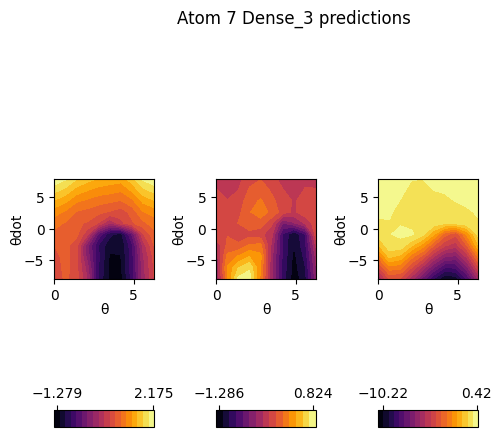

In [37]:
modelviz_pendulum_utils.plot_neuron_activations(activations_layer=atom_activations_alllayers['Dense_3'], 
                                                neuron_idx = 'all', 
                                                figlabel=f'Atom {atom_i} Dense_3 predictions', 
                                                xpos=theta_all, ypos=thetadot_all, normalize=False)

### Entropy

analyze the entropy of neuron activations with respect to specific input dimensions - theta and velocity  - get for each layer
- entropy over layers
- or entropy wrt source states

https://link.springer.com/chapter/10.1007/978-3-030-41117-6_3 - entropy reduces with layer depth? ; the neuron activation patterns become more and more stable with the depth of the fully connected layers



In [89]:
from scipy.stats import entropy

In [90]:
def plot_activations(activations_2d,vmin,vmax):
        plt.figure(figsize=(3, 3))
        plt.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20,vmin=vmin,vmax=vmax)  # Theta vs Angular vel
        plt.colorbar(label='Activation')
        plt.xlabel('Theta (radians)')
        plt.ylabel('Angular vel')
        plt.title('Neuron Activations')
        plt.legend()
        plt.show()


def compute_histogram_entropy(samples, num_bins=10): ## Original
    """Compute entropy from sample data using histograms."""
    # # Create histogram (density=True normalizes to get probabilities)
    # hist, bin_edges = np.histogram(samples, bins=num_bins, density=True)
    
    # # Normalize histogram to get probabilities
    # hist = hist + 1e-10  # To avoid log(0)
    # # hist_prob = hist/np.sum(hist)
    
    # # Entropy calculation using discrete entropy formula
    # hist_entropy = -np.sum(hist * np.log(hist))
    # # hist_entropy = entropy(hist_prob+ 1e-10 ) 
    # return hist_entropy

    # Compute the histogram of pixel intensities for the row
    hist, bin_edges = np.histogram(samples, bins=20, density=True)
    # Add a small value to avoid log(0) issues
    hist = hist + 1e-10
    # Compute entropy for the row
    row_entropy = entropy(hist, base=2)    
    # Return the average entropy across all rows
    return row_entropy #np.mean(row_entropy)

# def compute_entropy_activations(activations, label=None, plot_normalized = False,normalize=True):
#     # Apply to handle negative activations and normalize
#     normalized_activations = (activations - np.amin(activations)) / (np.amax(activations) - np.amin(activations)) #np.sum(activations, axis=1, keepdims=True)
#     normalized_activations = normalized_activations/normalized_activations.sum()
#     normalized_activations = normalized_activations[normalized_activations>0] # remove zeros
#     if plot_normalized:
#         plt.figure()
#         plt.plot(normalized_activations, label=label)
#     # entropy = -np.sum(normalized_activations * np.log(normalized_activations + 1e-9))/np.log(2)  # Adding a small value to prevent log(0)
#     # return entropy #/normalized_activations.shape[0]
#     activation_entropy =  entropy(normalized_activations, base=2)
#     # activation_entropy =  entropy(normalized_activations, base=len(normalized_activations)) #TODO - ask standard practice of base
#     return activation_entropy


In [93]:
def compute_entropy_vel_angle_neuron(activations_all,layer, neuron_idx,  normalize=True):
    activations_selected = activations_all[layer][:, neuron_idx]
    activations_2d = activations_selected.reshape(len(thetadot_all), len(theta_all))
    distr_velocity = np.mean(activations_2d, axis=1)
    distr_angles = np.mean(activations_2d, axis=0)
    
    # print(distr_angles.shape)
    # plt.plot(distr_angles,label='distr_angles')
    # plt.plot(distr_velocity,label='distr_velocity')
    # plt.hist(distr_angles, bins=20, density=True, color='skyblue', alpha=0.7)
    # plt.hist(distr_velocity, bins=20, density=True, color='k', alpha=0.7)
        
    entropy_vel = compute_histogram_entropy(distr_velocity, num_bins=10) #compute_entropy_activations(distr_velocity, normalize=normalize)
    entropy_angles = compute_histogram_entropy(distr_angles, num_bins=10) #compute_entropy_activations(distr_angles, normalize=normalize)
    return np.round(entropy_vel,2), np.round(entropy_angles,2) #, entropy_all

layer = 'Dense_3' 
neuron_idx = 2
entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
print(f'Layer {layer} , Neuron_idx: {neuron_idx}, \nEntropy wrt velocity',entropy_vel, '\nEntropy wrt angles',entropy_angles)

del entropy_vel, entropy_angles

Layer Dense_3 , Neuron_idx: 2, 
Entropy wrt velocity 2.65 
Entropy wrt angles 2.45


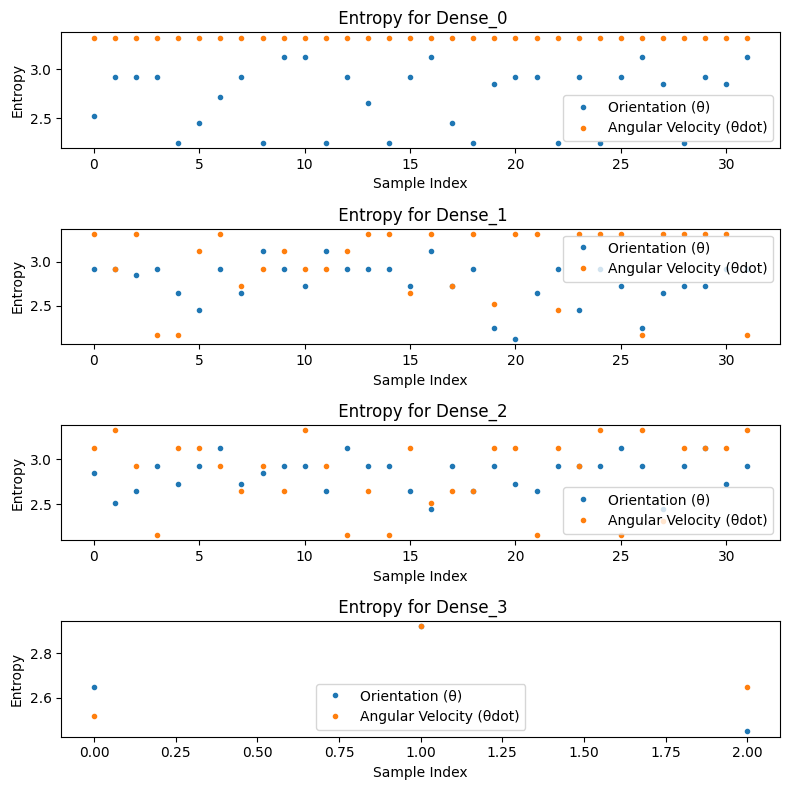

In [103]:
#TODO: ask - might depend on how we normalize - I did minmax not softmax , also - one latent
#TODO - do for multiple latents? all atoms?

def plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    n_layers = len(layer_names)
    fig, axs = plt.subplots(n_layers, 1, figsize=(8, n_layers * 2))
    if n_layers == 1:
        axs = np.array([axs])
    for i, layer in enumerate(layer_names):
        axs[i].plot(angle_entropy_all[layer],'.',label='Orientation (θ)')
        axs[i].plot(vel_entropy_all[layer],'.',label='Angular Velocity (θdot)')
        axs[i].set_title(f' Entropy for {layer}') # with Min-max Norm')
        axs[i].set_xlabel('Sample Index')
        axs[i].set_ylabel('Entropy')
        axs[i].legend()

    # fig.suptitle(f'ATOM {atom_i}: (ONE SAMPLE) Entropy of each layers Neuron activations wrt angles and velocity')
    plt.tight_layout()
    plt.show()

atom_i = 7  # ith atom
latent_rng_seed = 0
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers)

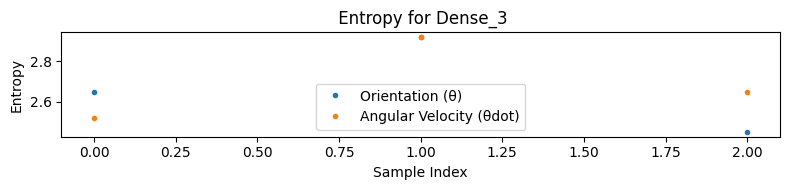

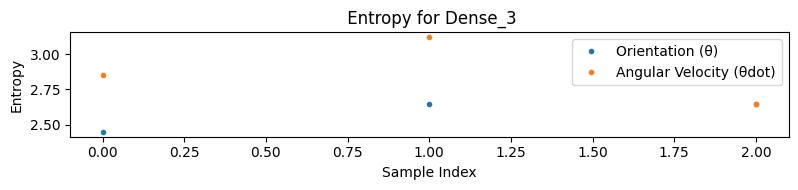

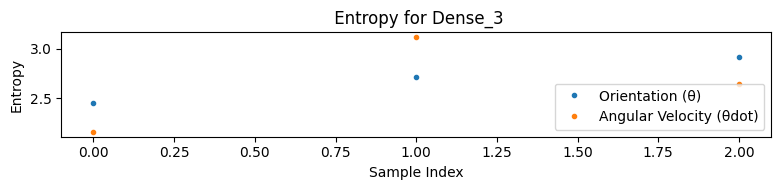

In [104]:
# check dense_3 - different latents
atom_i = 7  # ith atom
layers = ['Dense_3']
for latent_rng_seed in range(3):
    plot_entropies_layers_1atom(atom_i, latent_rng_seed, layers)


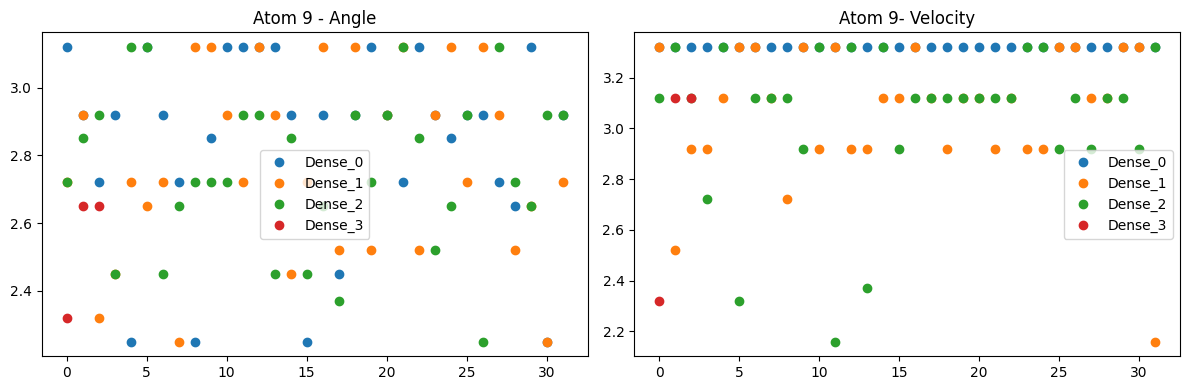

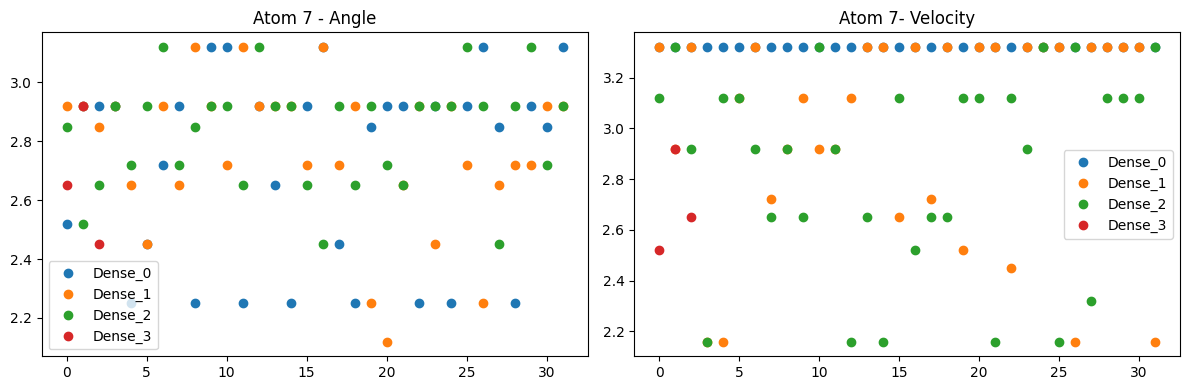

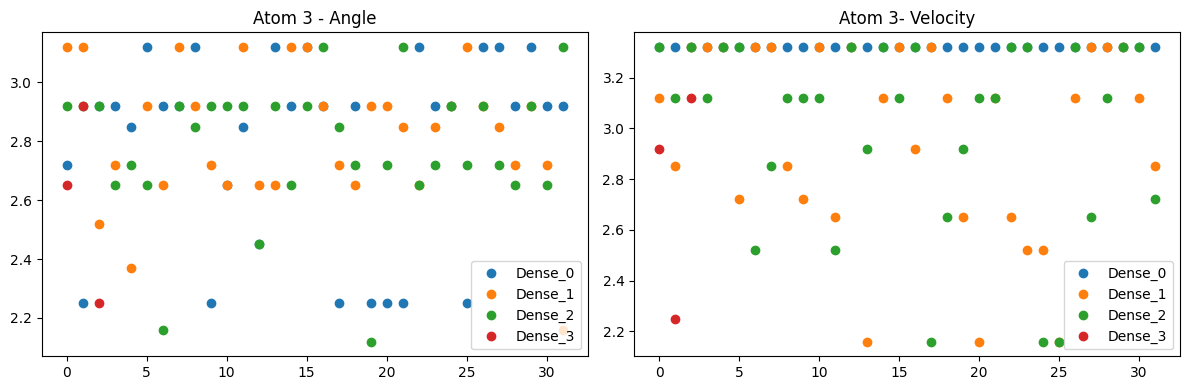

In [107]:
# Entropy of each layers Neuron activations wrt angles and velocity - one sample predictions

def choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers):
    atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
    # orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
    atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)
    layer_names = list(atom_activations_alllayers.keys())
    angle_entropy_all = {}
    vel_entropy_all = {}
    for layer in layer_names:
        angle_entropy_all[layer] = []
        vel_entropy_all[layer] = []
        for neuron_idx in range(atom_activations_alllayers[layer].shape[1]):
            entropy_vel, entropy_angles = compute_entropy_vel_angle_neuron(atom_activations_alllayers, layer, neuron_idx)
            angle_entropy_all[layer].append(entropy_angles) 
            vel_entropy_all[layer].append(entropy_vel)

    fig, axs = plt.subplots(1, 2, figsize=(12, len(layer_names)))  # 1 row, 2 columns
    axs[0].set_title(f'Atom {atom_i} - Angle')
    for layer in layer_names:
        axs[0].plot(angle_entropy_all[layer],'o',label=f'{layer}')
    axs[0].legend()
    axs[1].set_title(f'Atom {atom_i}- Velocity')
    for layer in layer_names:
        axs[1].plot(vel_entropy_all[layer],'o',label=f'{layer}')
    axs[1].legend()
    plt.tight_layout()
    plt.show()
    # plt.figure(figsize=(6, 4))
    # plt.title(f'Atom {atom_i}')
    # for layer in layer_names:
    #     plt.plot(angle_entropy_all[layer],'o',label=f'{layer} - Angle')
    # plt.legend()
    # plt.figure(figsize=(6, 4))
    # plt.title(f'Atom {atom_i}')
    # for layer in layer_names:
    #     plt.plot(vel_entropy_all[layer],'o',label=f'{layer} - Velocity')
    # plt.legend()

latent_rng_seed = 0  # ith atom
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# layers = ['Dense_3']

for atom_i in [9,7,3]:
    choose_entropies_alllayers_1atom(atom_i, latent_rng_seed, layers)

### Linear decoder

1. Train decoder to map neuron activations to source states 
2. Train decoder to map neuron activations to predicted state
- Single latent, different sources split as train and test

In [108]:
sources_all, theta_all, thetadot_all = get_states(30) 
sources_all.shape

(900, 3)

In [109]:
# Training data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge   #Linear least squares with l2 regularization.
# from sklearn.gaussian_process import GaussianProcessRegressor

train_sources, test_sources = train_test_split(sources_all, test_size=0.2, random_state=42)
print(train_sources.shape)


(720, 3)


In [110]:
# get model's predictions for all sources
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# single_layer = 'Dense_2'
# layers = [single_layer]
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']

#### Decoder from layer activations to source

R2 score for layer Dense_0: 0.9999999982943301
R2 score for layer Dense_1: 0.9982321865412477
R2 score for layer Dense_2: 0.9954399222326847
R2 score for layer Dense_3: 0.5269205421594669


Text(0.5, 1.0, 'Decoding source state - individual neuron predictions of each layer')

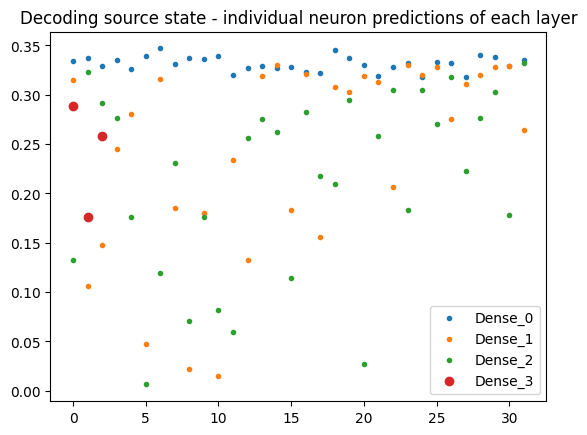

In [111]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_sources)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_sources)
    print(f'R2 score for layer {layer}: {layer_score}')

layer_names = list(train_activations_all.keys())
for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_sources)
        test_activations_neuron = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations_neuron,test_sources))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding source state - individual neuron predictions of each layer')

In [112]:
## Train with 1 latent  and Test with different latents - decoding source state 
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))

train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)


zs = jax.random.normal(jax.random.PRNGKey(20), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, test_sources,zs, layers)

# PREDICTING SOURCE STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_sources)

    # Original latent - different source
    layer_score = round(model_LR.score(test_activations_all[layer], test_sources), 3)
    print(f'--- Original latent - different source ::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = round(model_LR.score(train_activations_all_DIFF_LATENT[layer], train_sources), 3)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = round(model_LR.score(test_activations_all_DIFF_LATENT[layer], test_sources), 3)
    print(f'Different latent - different source ::: R2 score for layer {layer}: {layer_score}')


--- Original latent - different source ::: R2 score for layer Dense_0: 1.0
Different latent - same training source ::: R2 score for layer Dense_0: 0.873
Different latent - different source ::: R2 score for layer Dense_0: 0.87
--- Original latent - different source ::: R2 score for layer Dense_1: 0.998
Different latent - same training source ::: R2 score for layer Dense_1: 0.408
Different latent - different source ::: R2 score for layer Dense_1: 0.407
--- Original latent - different source ::: R2 score for layer Dense_2: 0.995
Different latent - same training source ::: R2 score for layer Dense_2: 0.857
Different latent - different source ::: R2 score for layer Dense_2: 0.851
--- Original latent - different source ::: R2 score for layer Dense_3: 0.527
Different latent - same training source ::: R2 score for layer Dense_3: 0.375
Different latent - different source ::: R2 score for layer Dense_3: 0.365


In [113]:
print(round(layer_score,3))

0.365


#### Decoder to end

R2 score for layer Dense_0: 0.715141773223877
R2 score for layer Dense_1: 0.9777020812034607
R2 score for layer Dense_2: 0.9833467602729797
R2 score for layer Dense_3: 0.9999998211860657


Text(0.5, 1.0, 'Decoding end state - individual neuron predictions of each layer')

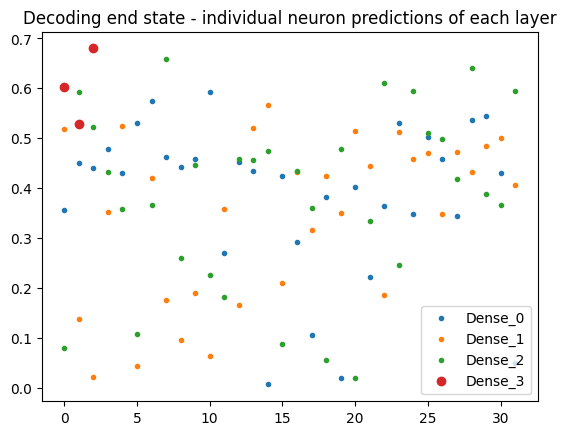

In [114]:
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
for layer in layer_names:
    model_LR = Ridge(alpha=0.1)
    train_activations_layer = train_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    model_LR.fit(train_activations_layer, train_endstate)
    test_activations_layer = test_activations_all[layer] #[:,neuron_idx].reshape(-1,1)
    # model_LR.predict(test_activations_layer)
    layer_score = model_LR.score(test_activations_layer,test_endstate)
    print(f'R2 score for layer {layer}: {layer_score}')
    # for neuron_idx in range(train_activations_all[layer].shape[1]):

for layer in layer_names:
    neuron_idx_all = np.arange(train_activations_all[layer].shape[1])
    neuron_r2_scores = []
    for neuron_idx in neuron_idx_all:
        model_LR = Ridge(alpha=0.1)
        train_activations_neuron = train_activations_all[layer][:,neuron_idx].reshape(-1,1)
        model_LR.fit(train_activations_neuron, train_endstate)
        test_activations = test_activations_all[layer][:,neuron_idx].reshape(-1,1)
        neuron_r2_scores.append(model_LR.score(test_activations,test_endstate))
    if layer=='Dense_3':
        plt.plot(neuron_r2_scores,'o',label=layer)
    else:
        plt.plot(neuron_r2_scores,'.',label=layer)
plt.legend()
plt.title('Decoding end state - individual neuron predictions of each layer')

In [115]:
## Train with 1 latent  and Test with different latents - decoding end state

layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
zs = jax.random.normal(jax.random.PRNGKey(0), (num_latent_dims,))
train_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, train_sources,zs, layers)
train_endstate = train_activations_all['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate = test_activations_all['Dense_3']


zs = jax.random.normal(jax.random.PRNGKey(42), (num_latent_dims,))
train_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, train_sources,zs, layers)
train_endstate_DIFF_LATENT = train_activations_all_DIFF_LATENT['Dense_3']
# train_activations_all[single_layer].shape
test_activations_all_DIFF_LATENT = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator,atom_params, test_sources,zs, layers)
test_endstate_DIFF_LATENT = test_activations_all_DIFF_LATENT['Dense_3']

# PREDICTING END STATE
layer_names = list(train_activations_all.keys())
# layer_r2_scores = [] # 1- normalized least squares regression score (best 1,can be -ve)
print('predicting end state')
for layer in layer_names:
    print('Layer:',layer)
    model_LR = Ridge(alpha=0.1)
    model_LR.fit(train_activations_all[layer], train_endstate)

    # Original latent - different source
    layer_score = model_LR.score(test_activations_all[layer],test_endstate)
    print(f'--- Original latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
    
    # Different latent - same source as training
    layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate_DIFF_LATENT)
    print(f'Different latent - same training source ::: R2 score for layer {layer}: {layer_score}')

    # Different latent - different source
    layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate_DIFF_LATENT)
    print(f'Different latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')


predicting end state
Layer: Dense_0
--- Original latent - different source (test_sources)::: R2 score for layer Dense_0: 0.715141773223877
Different latent - same training source ::: R2 score for layer Dense_0: -0.5664746761322021
Different latent - different source (test_sources)::: R2 score for layer Dense_0: -0.6673162579536438
Layer: Dense_1
--- Original latent - different source (test_sources)::: R2 score for layer Dense_1: 0.9777020812034607
Different latent - same training source ::: R2 score for layer Dense_1: -5.543369293212891
Different latent - different source (test_sources)::: R2 score for layer Dense_1: -6.198400020599365
Layer: Dense_2
--- Original latent - different source (test_sources)::: R2 score for layer Dense_2: 0.9833467602729797
Different latent - same training source ::: R2 score for layer Dense_2: -0.10784182697534561
Different latent - different source (test_sources)::: R2 score for layer Dense_2: -0.23581308126449585
Layer: Dense_3
--- Original latent - diff

In [116]:
# Gettting score with WRONG latent for predictions - implying latent isn't very important
layer_score = model_LR.score(test_activations_all_DIFF_LATENT[layer],test_endstate)
print(f'Wrong latent - different source (test_sources)::: R2 score for layer {layer}: {layer_score}')
layer_score = model_LR.score(train_activations_all_DIFF_LATENT[layer],train_endstate)
print(f'Wrong latent - different source (train_sources)::: R2 score for layer {layer}: {layer_score}')

Wrong latent - different source (test_sources)::: R2 score for layer Dense_3: 0.002586543560028076
Wrong latent - different source (train_sources)::: R2 score for layer Dense_3: 0.05219985917210579


### tsne umap

In [117]:
sources_all, theta_all, thetadot_all = get_states(30) 
thetas = np.arctan2(sources_all[:, 1], sources_all[:, 0]) % (2 * np.pi)
velocities = sources_all[:, -1]
layers_all = ['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'] 
atom_i = 7
latent_rng_seed = 0
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# orig zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
atom_activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, 
                                                                                                     sources_all, zs, layers_all)

In [118]:
# train_activations_layer = atom_activations_alllayers['Dense_2']
# gen_hidden = train_activations_layer 
# # Perform SVD on the hidden representations of the generator and discriminator
# U_gen, s_gen, V_gen = np.linalg.svd(gen_hidden, full_matrices=False)

# # intrinsic dimensionaity of hidden space captured here 
# # - most of varance captured by first few singular values - dim of data captured in fewer components

# # 1. Plot the singular values (s_gen, s_disc) to analyze variance captured
# plt.figure(figsize=(8, 6))
# plt.plot(s_gen, label='Generator Singular Values')
# plt.title('Singular Values: Generator vs Discriminator')
# plt.xlabel('Singular Value Index')
# plt.ylabel('Magnitude')
# plt.xlim(0, 5)
# plt.legend()
# plt.show()

# # 2. Dimensionality reduction using the first two columns of U (Principal Components)
# # Plot first two principal components from generator hidden representations
# plt.figure(figsize=(8, 6))
# plt.scatter(U_gen[:, 0], U_gen[:, 1], c='blue', label='Generator Hidden PCs')
# plt.title('Generator Hidden Representations (First Two Principal Components)')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.legend()
# plt.show()

# # 3. Investigate the V matrices (Right Singular Vectors)
# # Plot the heatmap of the first 10 right singular vectors (columns of V) to understand hidden units' influence
# # how the hidden units are distributed across the singular vectors - to identify most important hidden units contributing to network's variance
# plt.figure(figsize=(10, 6))
# plt.imshow(V_gen[:10, :], aspect='auto', cmap='hot')
# plt.title('Heatmap of First 10 Right Singular Vectors (Generator)')
# plt.xlabel('Hidden Units')
# plt.ylabel('Singular Vector Index')
# plt.colorbar()
# plt.show()


# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram
# # 4. Hierarchical clustering of the generator hidden representations using U_gen
# data_dist = pdist(U_gen[:, :2])  # Use first 2 PCs for clustering
# data_link = linkage(data_dist)

# plt.figure(figsize=(10, 7))
# dendrogram(data_link)
# plt.title('Hierarchical Clustering of Generator Hidden Representations (First 2 PCs)')
# plt.show()


In [119]:
# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram
# # 4. Hierarchical clustering of the generator hidden representations using U_gen
# data_dist = pdist(U_gen[:200, :2])  # Use first 2 PCs for clustering
# data_link = linkage(data_dist)

# plt.figure(figsize=(10, 7))
# dendrogram(data_link)
# plt.title('Hierarchical Clustering of Generator Hidden Representations (First 2 PCs)')
# plt.show()


In [123]:
# !pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 11.6 MB/s eta 0:00:0000:0100:01


In [135]:
# !pip install umap-learn

In [137]:
# !python -m pip install umap-learn
from sklearn.manifold import TSNE
import umap.umap_ as umap


/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [125]:
# 2 component t-SNE
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
tsne_2comp = {}
for layer in layer_names:
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    tsne = TSNE(n_components=2, random_state=0)
    projections = tsne.fit_transform(train_activations_layer)
    tsne_2comp[layer] = projections

/tmp/ipykernel_21063/2368364939.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis').reversed()


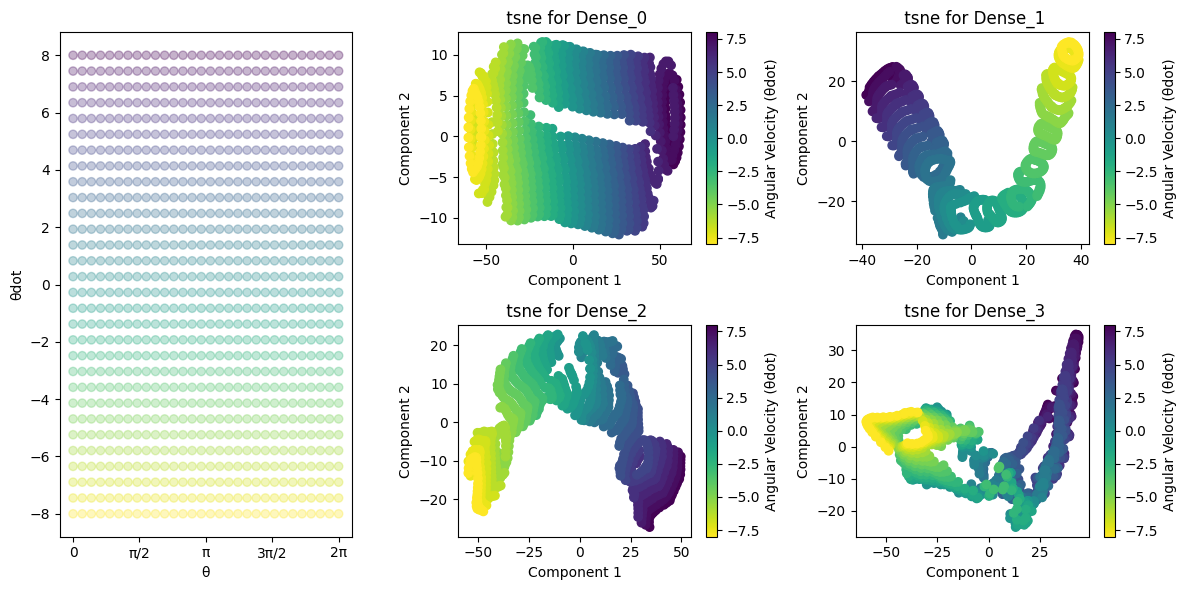

In [126]:
from matplotlib import gridspec
reversed_map = plt.cm.get_cmap('viridis').reversed() 

fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(thetas, velocities, alpha=0.3, c=velocities, cmap=reversed_map)  # Use the numbers as colors
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
ax.set_xlabel('θ')
ax.set_ylabel('θdot')
# fig.suptitle('Source states - colored by velocities')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=velocities, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='Angular Velocity (θdot)')

plt.tight_layout()
plt.show()

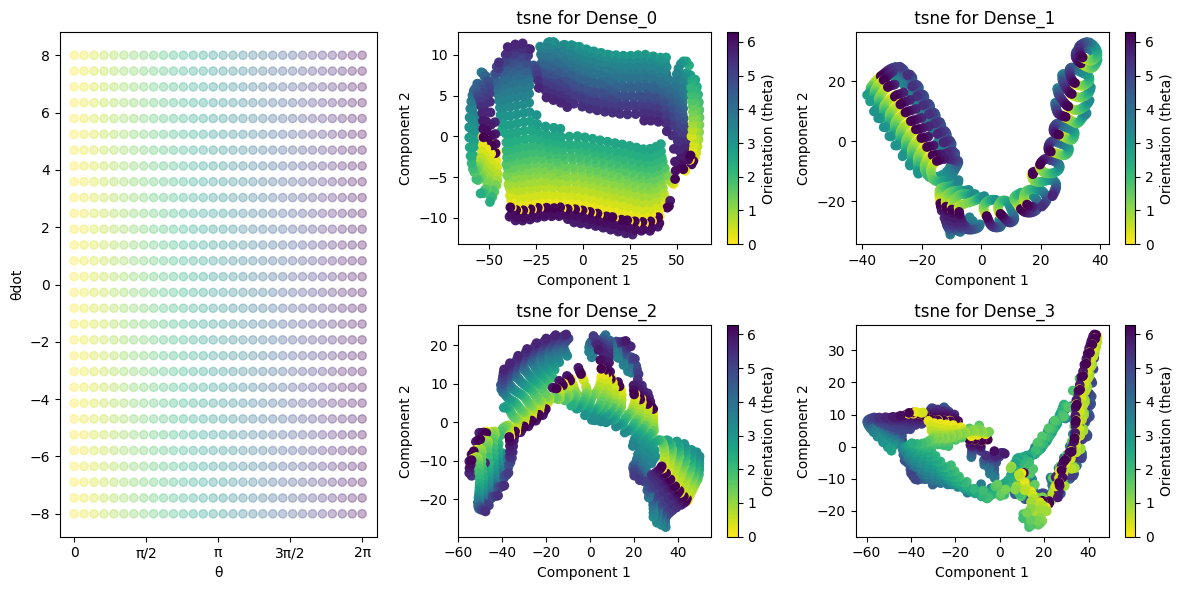

In [127]:
# 2 component t-SNE
fig = plt.figure(figsize=(12,6))  # Adjust the figure size
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])  # 2 rows, 3 columns

# Add your centered plot to the left column
ax = plt.subplot(gs[:, 0])  # This plot spans all rows and the first column
# Add your plot code here
ax.scatter(thetas, velocities, alpha=0.3, c=thetas, cmap=reversed_map)  # Use the numbers as colors
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", "π/2", "π", "3π/2", "2π"])
ax.set_xlabel('θ')
ax.set_ylabel('θdot')
# fig.suptitle('Source states - colored by thetas')

for i, layer in enumerate(layer_names):
    ax = plt.subplot(gs[i//2, i%2+1])  # Adjust the indices to leave the first column empty
    scatter = ax.scatter(tsne_2comp[layer][:, 0],tsne_2comp[layer][:, 1],c=thetas, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    fig.colorbar(scatter, ax=ax, label='Orientation (theta)')

plt.tight_layout()
plt.show()


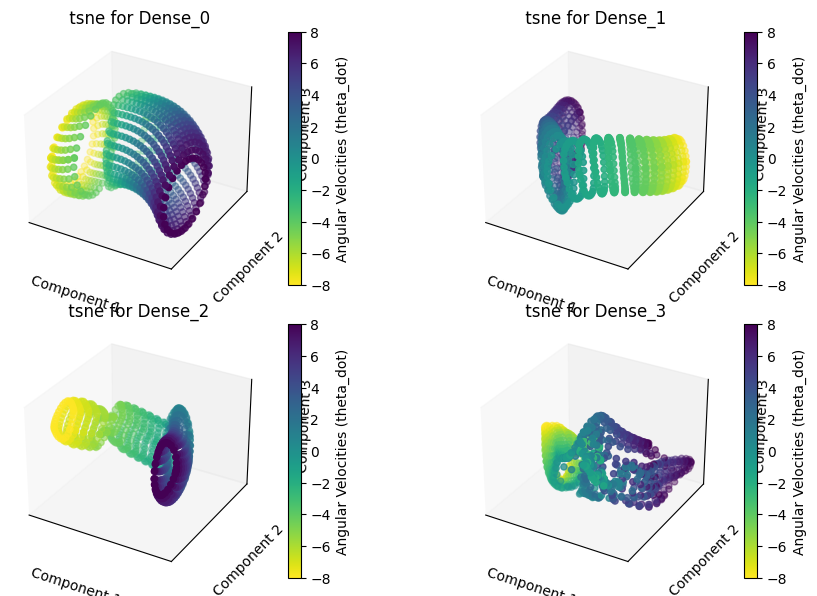

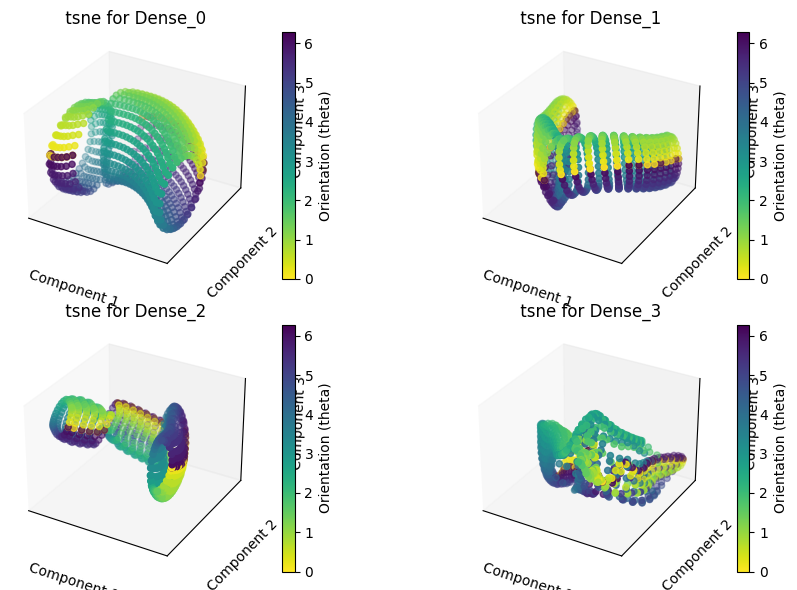

In [128]:
# 3 component tsne
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
tsne_3comp = {}
for layer in layer_names:
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    tsne = TSNE(n_components=3, random_state=0)
    projections = tsne.fit_transform(train_activations_layer)
    tsne_3comp[layer] = projections

# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')  # 2 rows, 2 columns
    scatter = ax.scatter(tsne_3comp[layer][:, 0], tsne_3comp[layer][:, 1], tsne_3comp[layer][:, 2],c=velocities, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_xticks([])  # Remove xticks
    ax.set_yticks([])
    ax.set_zticks([])
    fig.colorbar(scatter, ax=ax, label='Angular Velocities (theta_dot)')
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(10,6)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')  # 2 rows, 2 columns
    scatter = ax.scatter(tsne_3comp[layer][:, 0], tsne_3comp[layer][:, 1], tsne_3comp[layer][:, 2],c=thetas, cmap=reversed_map)
    ax.set_title(f' tsne for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_xticks([])  # Remove xticks
    ax.set_yticks([])
    ax.set_zticks([])
    fig.colorbar(scatter, ax=ax, label='Orientation (theta)')
plt.tight_layout()
plt.show()

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed f

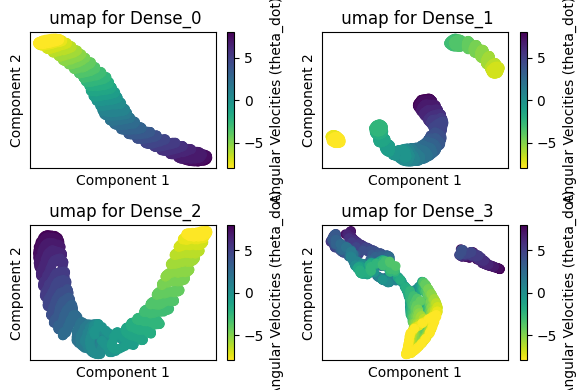

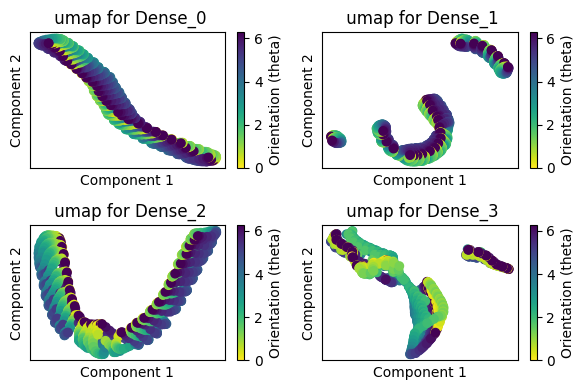

In [142]:
# UMAP 2D 
layer_names = list(atom_activations_alllayers.keys())
n_layers = len(layer_names)
umap_all2d = {}
for layer in layer_names:
    umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
    train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
    umap_all2d[layer] = umap_2d.fit_transform(train_activations_layer)

fig = plt.figure(figsize=(6,4)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1) 
    scatter = ax.scatter(umap_all2d[layer][:, 0],umap_all2d[layer][:, 1], c = velocities, cmap = reversed_map)
    ax.set_title(f' umap for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_xticks([])  # Remove xticks
    ax.set_yticks([])
    # axs[i].legend()
    fig.colorbar(scatter, ax=ax, label='Angular Velocities (theta_dot)')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6,4)) 
for i, layer in enumerate(layer_names):
    ax = fig.add_subplot(2, 2, i+1) 
    scatter = ax.scatter(umap_all2d[layer][:, 0],umap_all2d[layer][:, 1], c = thetas, cmap = reversed_map)
    ax.set_title(f' umap for {layer}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_xticks([])  # Remove xticks
    ax.set_yticks([])
    # axs[i].legend()
    fig.colorbar(scatter, ax=ax, label='Orientation (theta)')
plt.tight_layout()

In [ ]:
# # UMAP 3D
# layer_names = list(atom_activations_alllayers.keys())
# n_layers = len(layer_names)
# umap_all3d = {}
# for layer in layer_names: 
#     umap_3d = UMAP(n_components=3, init='random', random_state=0)
#     train_activations_layer = atom_activations_alllayers[layer] #[:,neuron_idx].reshape(-1,1)
#     umap_all3d[layer] = umap_3d.fit_transform(train_activations_layer)

# fig = plt.figure(figsize=(8,6))
# for i, layer in enumerate(layer_names):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     scatter = ax.scatter(umap_all3d[layer][:, 0], umap_all3d[layer][:, 1], umap_all3d[layer][:, 2],c=velocities, cmap=reversed_map)
#     ax.set_title(f' umap for {layer}')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     fig.colorbar(scatter, ax=ax, label='velocities')
# plt.tight_layout()
# plt.show()
# fig = plt.figure(figsize=(8,6))
# for i, layer in enumerate(layer_names):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     scatter = ax.scatter(umap_all3d[layer][:, 0], umap_all3d[layer][:, 1], umap_all3d[layer][:, 2],c=thetas, cmap=reversed_map)
#     ax.set_title(f' umap for {layer}')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     fig.colorbar(scatter, ax=ax, label='Theta')
# plt.tight_layout()
# plt.show()


In [ ]:
# different sources, so no color basis - maybe generate for different latents and color same source? #TODO


### Effect of different latents 

In [34]:
atom_i = 7
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
layers = ['Dense_3']
activations_layers_randomz = []
for i in np.random.randint(0,100,size=5):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
    activations_layers_randomz.append(activations_layer)


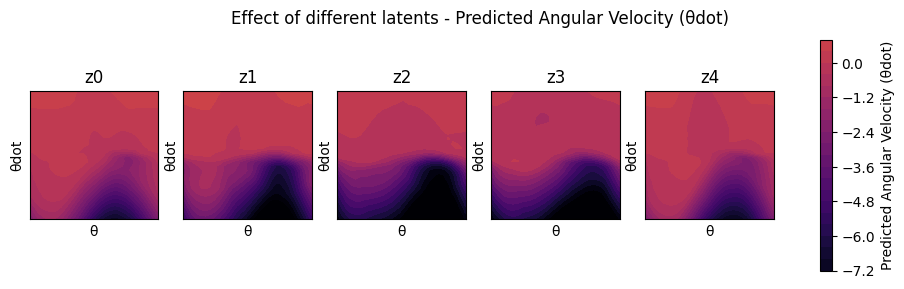

In [144]:
# neuron_idx = 2
# # Plot with respect to theta arctan(neuron1 output, neuron2 output)
# # from mpl_toolkits.axes_grid1 import make_axes_locatable
# n = len(activations_layers_randomz)
# cols = 5 
# rows = n // cols 
# position = range(1,n + 1)
# fig = plt.figure(figsize=(12,3))
# global_min = -8
# global_max = 8
# scatters = []
# for k, activations_layer in enumerate(activations_layers_randomz): 
#     ax = fig.add_subplot(rows, cols, position[k])
#     thetadot = activations_layer[:,2]
#     activations_2d = thetadot.reshape(len(thetadot_all), len(theta_all))
#     scatter = ax.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
#     scatters.append(scatter)
#     ax.set_box_aspect(1)
#     ax.set_title(f'z{k}')
#     plt.xticks([]), plt.yticks([]) 
#     ax.set_xlabel('θ')
#     ax.set_ylabel('θdot')
# fig.colorbar(scatters[0], ax=fig.get_axes(), label='Predicted Angular Velocity (θdot)')
# fig.suptitle('Effect of different latents - Predicted Angular Velocity (θdot)')
# plt.show()

# # modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layers_randomz, 'zs', #'latent rng key'
#                                                                     #   neuron_idx, theta_all, thetadot_all, normalize=False, title=f'atom:{atom_i} {layers} neuron:{neuron_idx} rate maps for different latents')

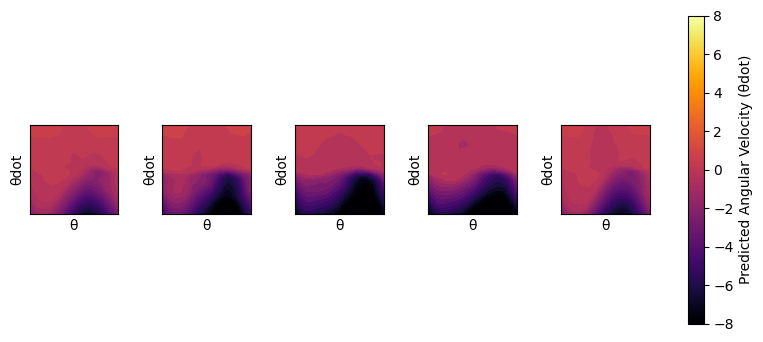

In [149]:
plot_atom_activations_wrt_chosen_source_dim(activations_layers_randomz, theta_all, thetadot_all, srcdim='ang_velocity')


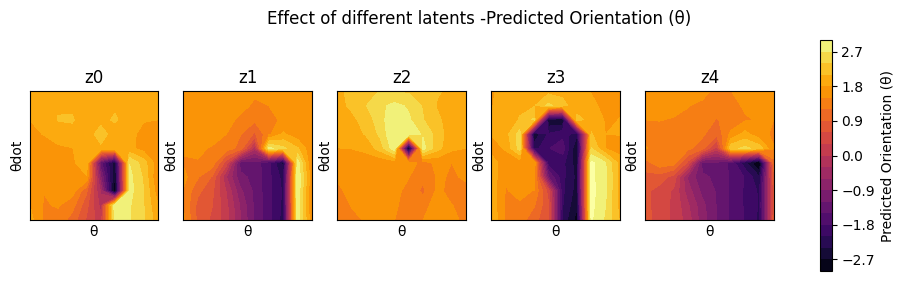

In [35]:
# Plot with respect to theta arctan(neuron1 output, neuron2 output)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
n = len(activations_layers_randomz)
cols = 5 
rows = n // cols 
position = range(1,n + 1)
fig = plt.figure(figsize=(12,3))
global_min = -np.pi
global_max = np.pi
scatters = []
for k, activations_layer in enumerate(activations_layers_randomz): 
    ax = fig.add_subplot(rows, cols, position[k])
    theta = np.arctan2(activations_layer[:, 0], activations_layer[:, 1])
    activations_2d = theta.reshape(len(thetadot_all), len(theta_all))
    scatter = ax.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
    scatters.append(scatter)
    ax.set_box_aspect(1)
    ax.set_title(f'z{k}')
    plt.xticks([]), plt.yticks([]) 
    ax.set_xlabel('θ')
    ax.set_ylabel('θdot')
fig.colorbar(scatters[0], ax=fig.get_axes(), label='Predicted Orientation (θ)') 
fig.suptitle('Effect of different latents -Predicted Orientation (θ)')
plt.show()

Atom  9


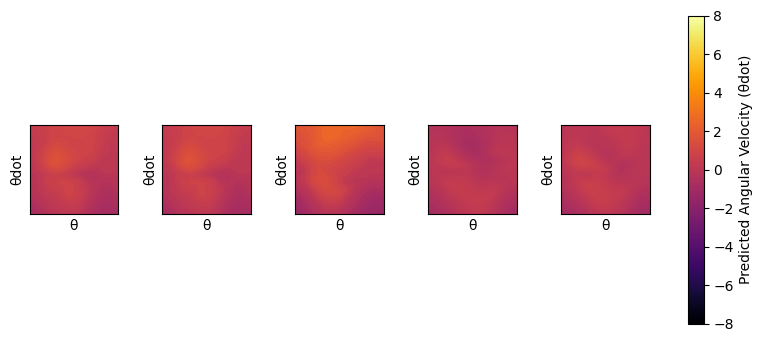

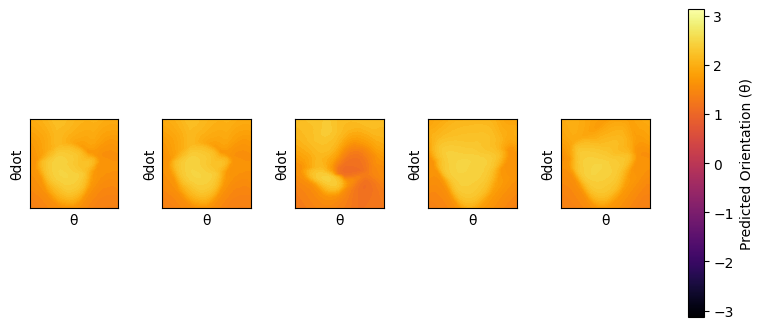

In [154]:
atom_i = 9
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
layers = ['Dense_3']
activations_layers_randomz = []
for i in np.random.randint(0,100,size=5):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
    activations_layers_randomz.append(activations_layer)
print('Atom ', atom_i)
plot_atom_activations_wrt_chosen_source_dim(activations_layers_randomz, theta_all, thetadot_all, srcdim='ang_velocity')
plot_atom_activations_wrt_chosen_source_dim(activations_layers_randomz, theta_all, thetadot_all, srcdim='orientation')


### Other Dense layers : Dense 0,1,2

activations_layer.shape: (900, 32)


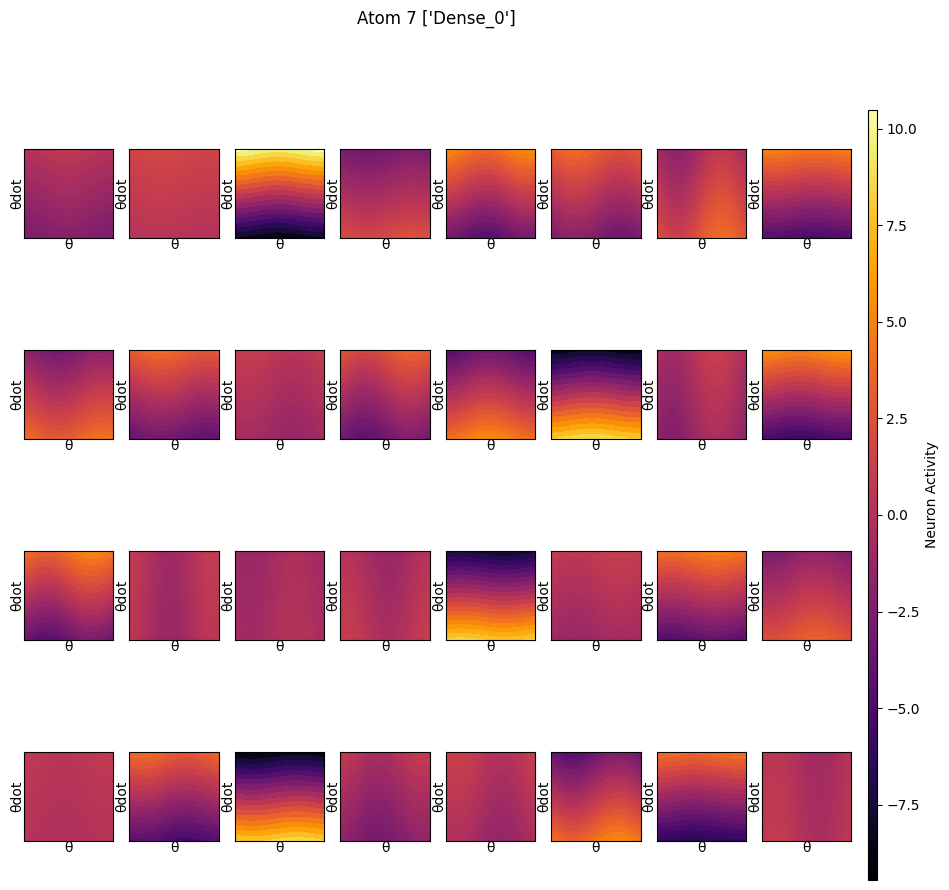

In [158]:
atom_i = 7
layers = ['Dense_0']
latent_rng_seed = 0 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(0, activations_layer.shape[-1])
figlabel = f'Atom {atom_i} {layers}'
modelviz_pendulum_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel, theta_all, thetadot_all, normalize=True)

activations_layer.shape: (900, 32)


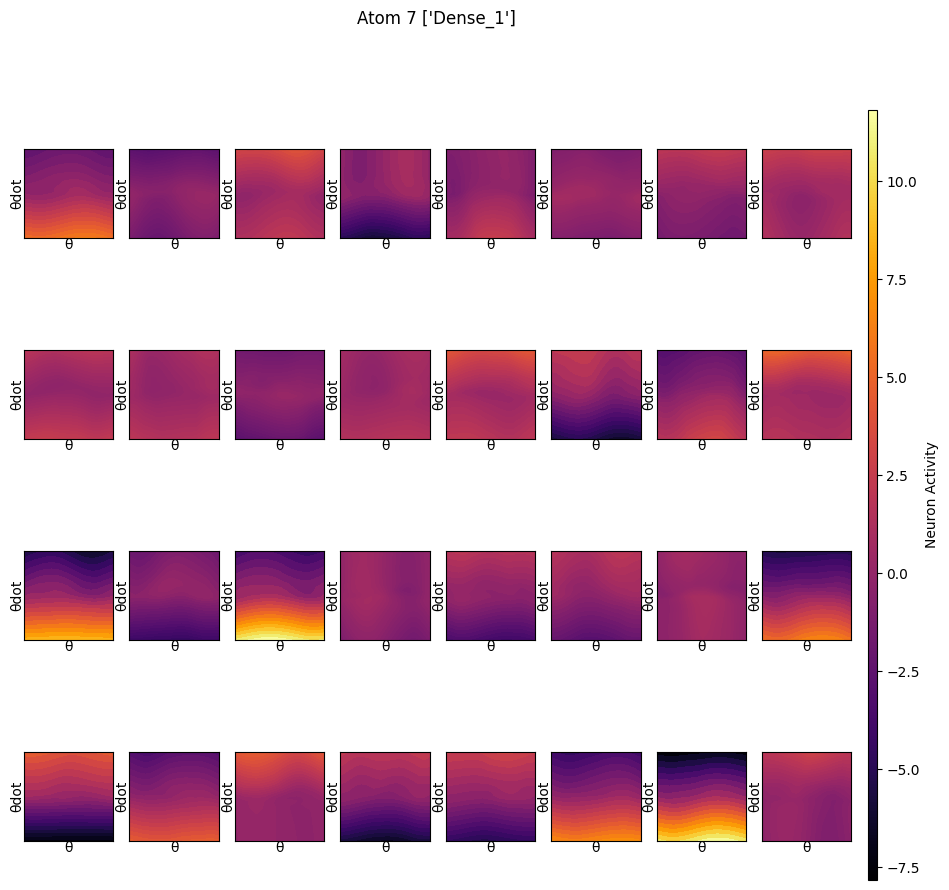

In [151]:
atom_i = 7
layers = ['Dense_1']
latent_rng_seed = 0 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(0, activations_layer.shape[-1])
figlabel = f'Atom {atom_i} {layers}'
modelviz_pendulum_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel, theta_all, thetadot_all, normalize=True)

activations_layer.shape: (900, 32)


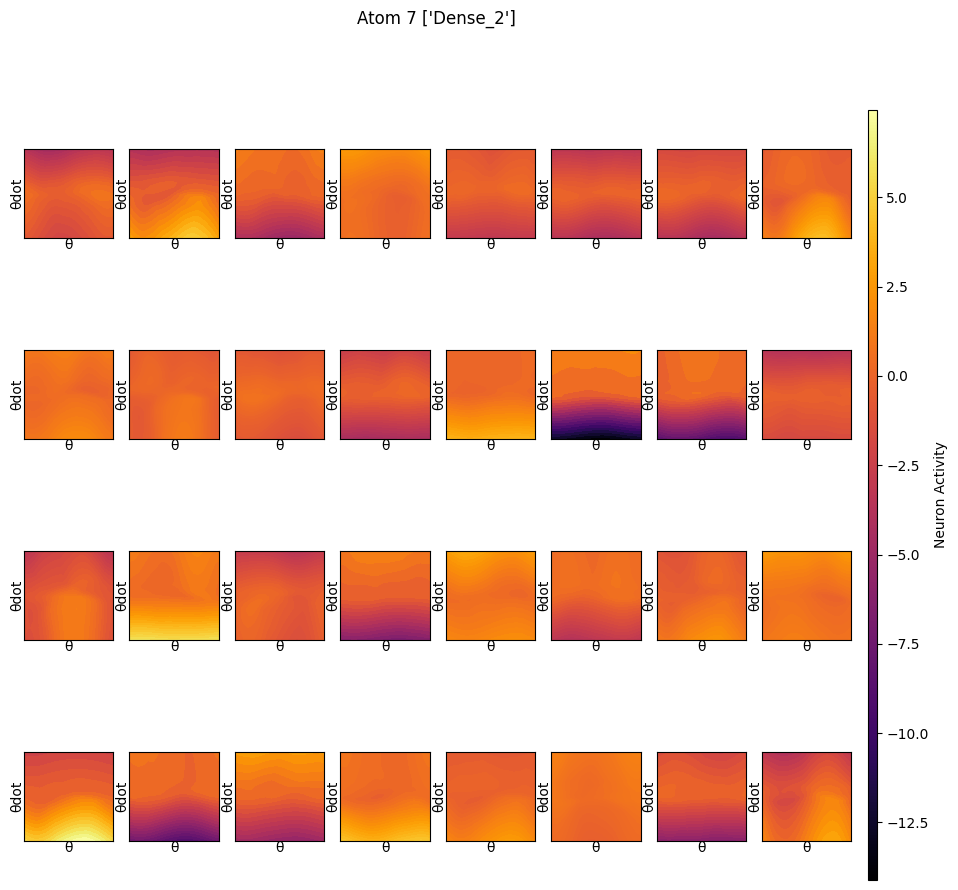

In [155]:
atom_i = 7
layers = ['Dense_2']
latent_rng_seed = 0 

atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, config.num_outer)
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all,zs, layers)
print(f'activations_layer.shape: {activations_layer.shape}')
neuron_idx = np.arange(0, activations_layer.shape[-1])
figlabel = f'Atom {atom_i} {layers}'
modelviz_pendulum_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel, theta_all, thetadot_all, normalize=True)


Other exp
- Different source states may generate same successor states
- Model will generate different successor states from the same source state (effect of different latents seeds, try giving all 5 same to diff sources)



DEBUG POLICY  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x75c84c7a3310>


[03:35:39] INFO     Converting library function __inference_converted_fun_tf_30                       ]8;id=79680;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py\tf2jax.py]8;;\:]8;id=427084;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py#986\986]8;;\

DEBUG pure_policy_func  <tf2jax._src.tf2jax.AnnotatedFunction object at 0x75c82c77cd00> policy_params  {}


/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:
/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:


debug actions min max -1.0 0.9999263


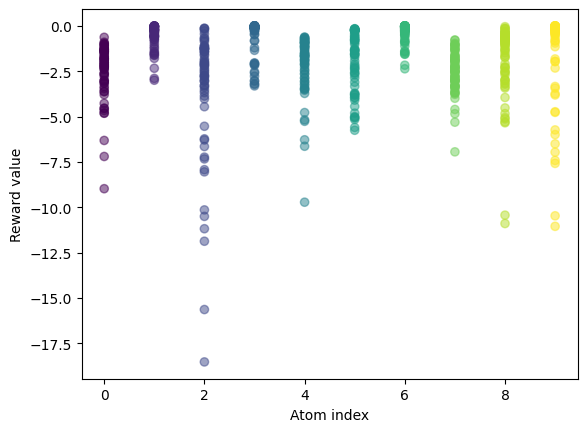

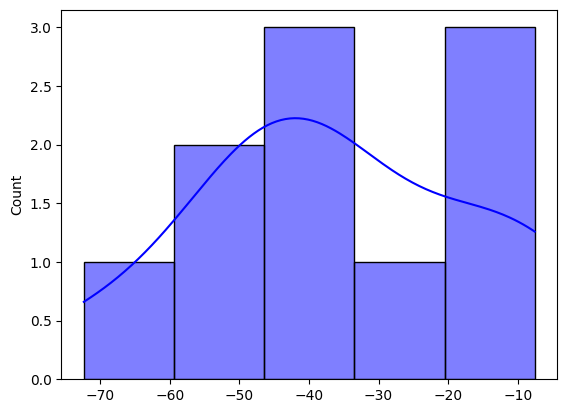

In [ ]:
# # Exploring actions and rewards of the 10 atoms for the samples above from  one source state
# ## Needs saved policy in pendulum dataset folder - from make_dataset_old code if tensorflow and jax versions allow

# # plotting utils
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# atom_idx_values = np.arange(samples.shape[0])
# norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))
# sm = ScalarMappable(cmap='tab10', norm=norm)

# policy = datasets.make_policy(config.env)
# def apply_policy_to_batch(batch):
#     keys,samples = batch
#     return jax.lax.map(lambda x: policy(x[0],x[1]),(keys,samples))
# keys = jax.random.split(jax.random.PRNGKey(0), np.prod(samples.shape[:-1]))
# keys = jnp.array(keys).reshape(*samples.shape[:-1], -1)
# actions = jax.lax.map(apply_policy_to_batch, (keys,samples))[1]
# print('debug actions min max',np.min(actions), np.max(actions))

# # # Assuming actions[1] has shape (10, 64, 1, 1)
# # # Reshape it to (10, 64)
# # reshaped_actions = actions.reshape(actions.shape[0], -1)
# # # for i in range(10):
# # #     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
# # x_coords = np.repeat(np.arange(reshaped_actions.shape[0]), reshaped_actions.shape[1])
# # # Flatten reshaped_actions) for plotting
# # flat_actions = reshaped_actions.flatten()
# # plt.scatter(x_coords, flat_actions, c=x_coords, alpha=0.5, cmap='viridis')
# # plt.xlabel('Atom index')
# # plt.ylabel('Action value')
# # plt.show()

# rewards = jax.vmap(jax.vmap(reward_fn))(samples, actions).squeeze()

# reshaped_rewards = rewards.reshape(rewards.shape[0], -1)
# # for i in range(10):
# #     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
# x_coords = np.repeat(np.arange(reshaped_rewards.shape[0]), reshaped_rewards.shape[1])
# # Flatten reshaped_actions) for plotting
# flat_rewards = reshaped_rewards.flatten()
# plt.scatter(x_coords, flat_rewards, c=x_coords, alpha=0.5, cmap='viridis')
# plt.xlabel('Atom index')
# plt.ylabel('Reward value')
# plt.show()

# reward_mean = rewards.mean(axis=-1) / (1.0 - config.gamma)  
# reward_mean.shape
# import seaborn as sns
# sns.histplot(reward_mean, kde=True, color='blue')